## Create a deep learning model for multi class image classification

### Import Libraries

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import numpy as np 
import pandas as pd 
import ibm_boto3
from botocore.client import Config

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math, time
%matplotlib inline

Using TensorFlow backend.


### Insert the train.zip file as streaming_body_1

### Unzip the input file and extract the filepaths

In [3]:
from io import BytesIO
import zipfile

unzip = zipfile.ZipFile(BytesIO(streaming_body_1.read()),'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

### The streaming_body_1 object will get saved in "/home/dsxuser/work" directory

# Prepare Training Data

In [4]:
import os

filenames = os.listdir('/home/dsxuser/work/train')
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'balasana':
        categories.append('balasana')
    elif category == 'garudasana':
        categories.append('garudasana')
    else :
        categories.append('padangusthasana')
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

### Shuffle dataframe rows

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
len(filenames)

30

In [7]:
df.head(10)

,filename,category
0,padangusthasana 4.jpg,padangusthasana
1,balasana 9.jpg,balasana
2,padangusthasana 1.jpg,padangusthasana
3,balasana 1.jpg,balasana
4,balasana 6.jpg,balasana
5,balasana 8.jpg,balasana
6,garudasana 6.jpg,garudasana
7,balasana 4.jpg,balasana
8,garudasana 4.jpg,garudasana
9,garudasana 3.jpg,garudasana


In [8]:
df.tail(10)

,filename,category
20,garudasana 9.jpg,garudasana
21,balasana 2.jpg,balasana
22,padangusthasana 6.jpg,padangusthasana
23,balasana 5.jpg,balasana
24,balasana 3.jpg,balasana
25,garudasana 0.jpg,garudasana
26,padangusthasana 8.jpg,padangusthasana
27,padangusthasana 2.jpg,padangusthasana
28,padangusthasana 5.jpg,padangusthasana
29,garudasana 7.jpg,garudasana


### See Total In count

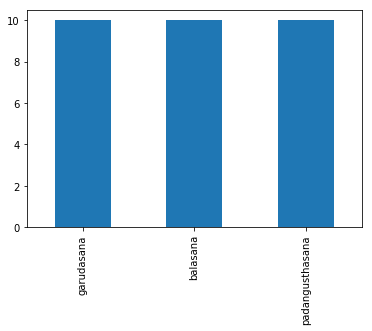

In [9]:
df['category'].value_counts().plot.bar()

From our data we have 10 images each of garudasana, balasana & padangusthasana

# See sample image

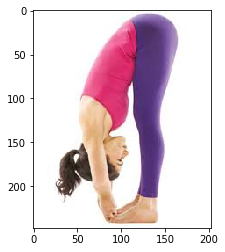

In [10]:
sample = random.choice(filenames)
image = load_img("/home/dsxuser/work/train/"+sample)
plt.imshow(image)

In [11]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.optimizers import rmsprop

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.30))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=rmsprop(lr=0.001), metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
batch_normalization_2

### Helper functions for optimizing the learning rate and computation time of the model

**Callbacks**

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 4 epochs and if val_loss value has not decreased.

In [13]:
earlystop = EarlyStopping(patience=4)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy does not increase for 2 steps

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

### Insert the validation.zip as streaming_body_2

In [17]:
unzip = zipfile.ZipFile(BytesIO(streaming_body_2.read()),'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [18]:
filenames = os.listdir('/home/dsxuser/work/validation')
categories = []
for filename in filenames:
    category = filename.split(' ')[0]
    if category == 'balasana':
        categories.append('balasana')
    elif category == 'garudasana':
        categories.append('garudasana')
    else :
        categories.append('padangusthasana')
        
df_valid = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

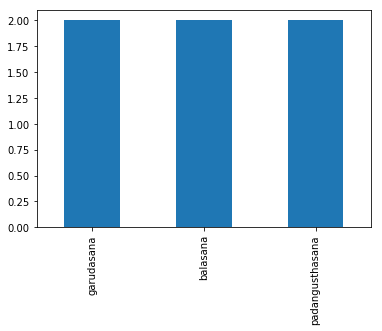

In [19]:
df_valid['category'].value_counts().plot.bar()

### Prepare Train & Validation Data

In [20]:
train_df = df
train_df = train_df.reset_index(drop=True)
validate_df = df_valid
validate_df = validate_df.reset_index(drop=True)

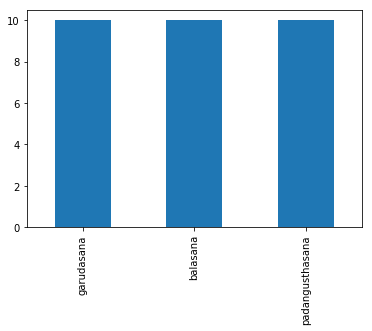

In [21]:
train_df['category'].value_counts().plot.bar()

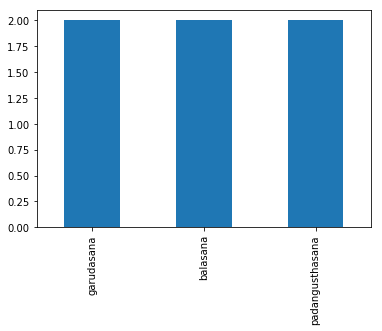

In [22]:
validate_df['category'].value_counts().plot.bar()

### We have 30 images for training & 6 images for validation

In [23]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=3

## Training Generator

In [24]:
from keras_preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/home/dsxuser/work/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 30 images belonging to 3 classes.


### Validation Generator

In [25]:
validation_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/home/dsxuser/work/validation/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

Found 6 images belonging to 3 classes.


# See how our generator works

In [26]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/home/dsxuser/work/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 images belonging to 1 classes.


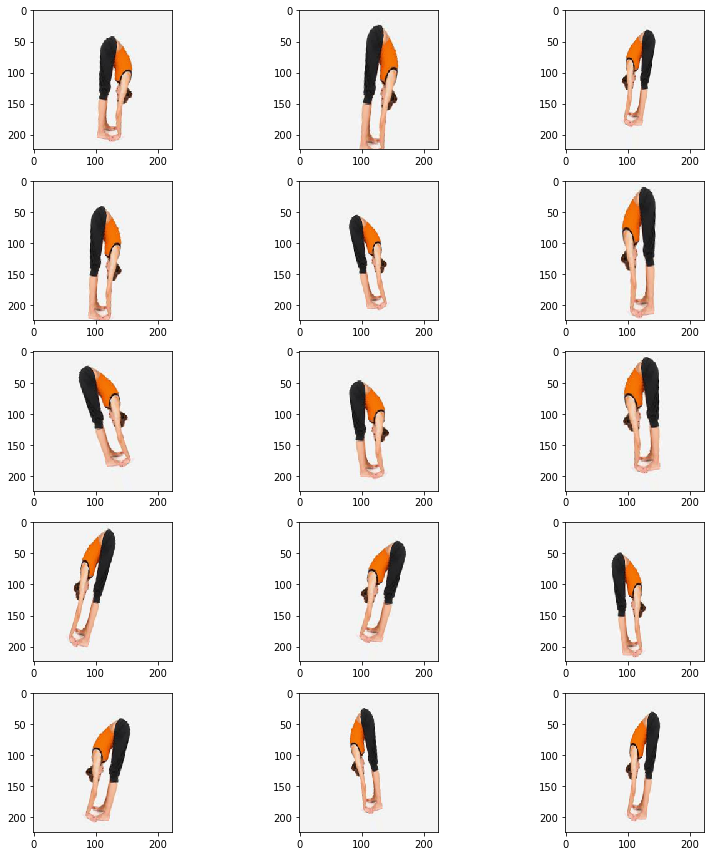

In [27]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Looks good!

# Create the Model

In [28]:
print('...Building Model...')
start = time.time()
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=15,
    steps_per_epoch=15,
    callbacks=callbacks
)
print("> Completion Time : ", time.time() - start)

...Building Model...
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
15/15 [==============================] - 37s 2s/step - loss: 1.0723 - acc: 0.5778 - val_loss: 3.2313 - val_acc: 0.2889
Epoch 2/10
15/15 [==============================] - 31s 2s/step - loss: 1.1169 - acc: 0.6444 - val_loss: 8.8808 - val_acc: 0.2667
Epoch 3/10
15/15 [==============================] - 32s 2s/step - loss: 0.9965 - acc: 0.6222 - val_loss: 2.6246 - val_acc: 0.4889
Epoch 4/10
15/15 [==============================] - 32s 2s/step - loss: 1.2371 - acc: 0.5556 - val_loss: 1.2986 - val_acc: 0.4444
Epoch 5/10
15/15 [==============================] - 32s 2s/step - loss: 0.7815 - acc: 0.6889 - val_loss: 2.0902 - val_acc: 0.4000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
15/15 [==============================] - 30s 2s/step - loss: 0.9600 - acc: 0.7111 - val_loss: 2.3674 - val_acc: 0.3333
Epoch 7/10
15/15 [==============================] - 32s 2s/step - loss

#### We can observe that the model has completed training in < 5 minutes. If there's more data, then training time will be longer with more layers and hyper parameters optimization.

#### Evaluate Model Accuracy

In [29]:
Training_Accuracy = model.evaluate_generator(generator=train_generator, steps=20)
Validation_Accuracy = model.evaluate_generator(generator=validation_generator, steps=20)

In [30]:
print("The Model Accuracy for Train data is: ", "{:.2%}".format(Training_Accuracy[1]))
print("The Model Accuracy for Validation data is: ", "{:.2%}".format(Validation_Accuracy[1]))

The Model Accuracy for Train data is:  83.33%
The Model Accuracy for Validation data is:  31.67%


# Virtualize Training

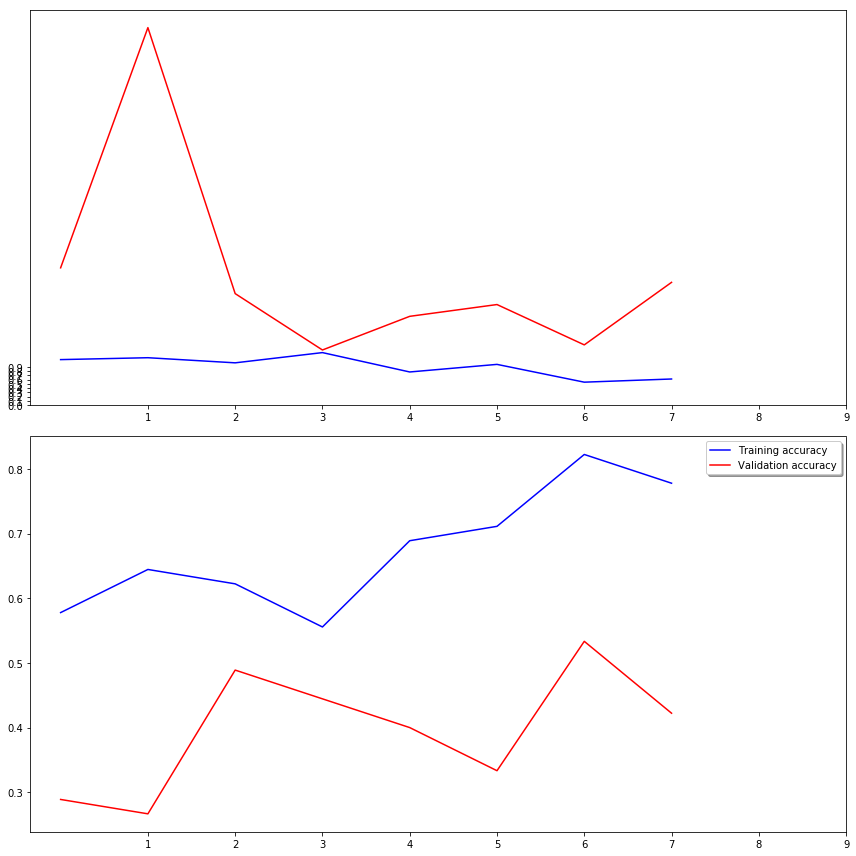

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### Insert the test.zip as streaming_body_3

In [33]:
unzip = zipfile.ZipFile(BytesIO(streaming_body_3.read()),'r')
file_paths = unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [34]:
test_filenames = os.listdir("/home/dsxuser/work/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator

In [35]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/dsxuser/work/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=1,
    shuffle=False
)

Found 6 images.


In [36]:
nb_samples

6

# Predict

In [37]:
test_generator.reset()
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples))

In [38]:
predicted_class_indices=np.argmax(predict,axis=1)

In [39]:
predicted_class_indices

array([2, 1, 2, 2, 0, 0])

In [40]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [41]:
predictions

['garudasana',
 'balasana',
 'garudasana',
 'garudasana',
 'padangusthasana',
 'padangusthasana']

In [42]:
filenames=test_generator.filenames
results=pd.DataFrame({"True Filename":filenames,
                      "Predicted Filename":predictions})
print(results)

           True Filename Predicted Filename
0         balasana 1.jpg         garudasana
1         balasana 2.jpg           balasana
2       garudasana 1.jpg         garudasana
3       garudasana 2.jpg         garudasana
4  padangusthasana 1.jpg    padangusthasana
5  padangusthasana 2.jpg    padangusthasana


### See predicted result with images

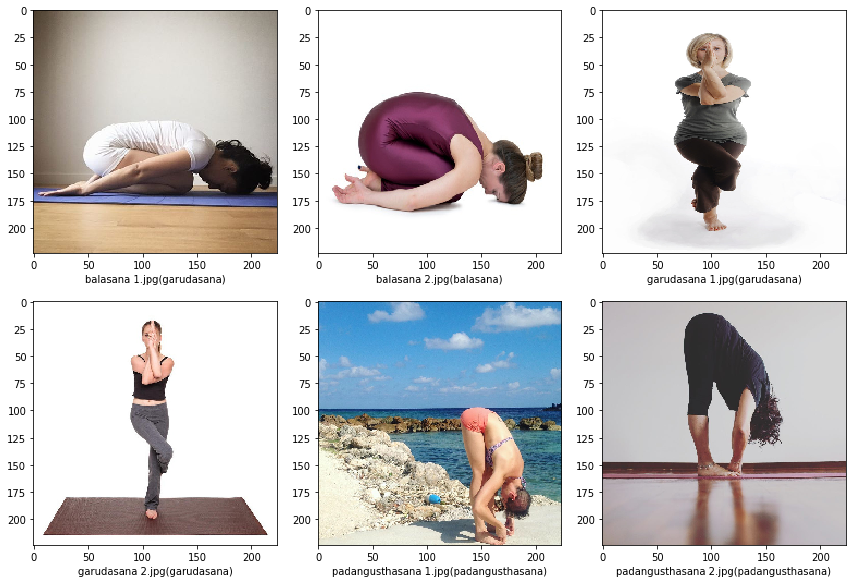

In [43]:
sample_test = results.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['True Filename']
    predictions = row['Predicted Filename']
    img = load_img("/home/dsxuser/work/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(predictions) + ')')
plt.tight_layout()
plt.show()

### The model has identified five out of six images accurately in the test data with the accuracy of 84%.

#### Save the test predictions as CSV file

In [44]:
submission_df = results.copy()
submission_df.to_csv('submission.csv', index=False)

### Insert credentials of cloud object storage

In [ ]:
cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

def put_file(filepath, filename):
    '''Write file (csv, zip, pkl) to Cloud Object Storage'''
    resp = cos.upload_file(Filename=filepath,Bucket=credentials_1['BUCKET'],Key=filename)
    return resp

### Write the predictions in the csv file format  to cloud object storage

In [ ]:
filepath = '/home/dsxuser/work/submission.csv'
filename = 'Submission_results.csv'
put_file(filepath, filename)

### In this notebook, we have learnt how to ingest the images data into Watson Studio, build the model quickly, tune the hyper parameters, evaluate & write the predictions to cloud object storage which can be used for further analysis.